In [1]:
from random import seed as random_seed
random_seed(10)
from numpy.random import seed as np_random_seed
np_random_seed(10)
from tensorflow import set_random_seed as tf_set_random_seed
tf_set_random_seed(10)

/root/miniconda3/envs/tf13/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/root/miniconda3/envs/tf13/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/root/miniconda3/envs/tf13/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/root/miniconda3/envs/tf13/lib/python3.7/site-packages/tensorflow/pyth

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import sys
import cv2
from tqdm import tqdm
import glob

from keras import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras import initializers
import random
from skimage.transform import resize, rotate

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import precision_recall_fscore_support as score

from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

# Commented out IPython magic to ensure Python compatibility.
#from __future__ import print_function, division
# %matplotlib inline



Using TensorFlow backend.


In [3]:
def load_data(path,labels):
    
    images=[]
    class_label = 0
    classes=[]
    cnt=0
    for x in labels:
        c_path = path+x+'/'
        files = glob.glob(c_path+'*')
        files.sort()
        # Read all images
        for y in files:
            tmp = cv2.imread(y,cv2.IMREAD_GRAYSCALE)
            #print(tmp.shape)
            tmp = cv2.resize(tmp,(256,256),Image.ANTIALIAS)

            images.append(tmp)
            classes.append(class_label)
            
            cnt+=1
            if cnt%100==0:
                print(str(cnt)+' set finish!!')
        class_label+=1
    print('All of dataset are loaded!')    
    print('==========================================')
    
    return np.array(images),np.array(classes)

In [4]:
def preprocess_inceptionresnetv2(images):
    if len(images.shape)!=4:
        images = np.repeat(np.expand_dims(images,-1),3,-1)
    
    if not images.shape[1:3] == input_shape[0:2]:
        images = np.array([preprocess_input(cv2.resize(j, input_shape[0:2], cv2.INTER_CUBIC)) for j in tqdm(images)], dtype=np.float64)
    #images = np.y(np.reshape(images,(len(images),256,256,1)))
    
    return images
    

In [5]:
def list_to_arr(img_list):
    arr = []
    for x in img_list:

        arr.append(x[:,:,0])
        
    arr = np.asarray(np.reshape(arr,(len(img_list),x.shape[0],x.shape[1],1)))
    
    return arr

In [6]:
def rotate_img(labeled,classes,count,min_rads,max_rads):
    ratated_label = []
    new_label = []
    icnt=1
    
    for j in range(count):
        random_rads = [random.uniform(min_rads, max_rads) for zz in range(len(labeled))]
        for i in range(len(labeled)):
            labeled_rot = rotate(labeled[i], random_rads[i])
            ratated_label.append(labeled_rot)
            new_label.append(classes[i])
            if icnt%500==0:
                print(str(icnt)+' set rotated!')
            icnt+=1
        
    print('Done!==================================================')


    return np.array(ratated_label),np.array(new_label)

## Original Data (Just flip, not cropped)

In [7]:
label_list = ['class0','class1','class2','class3']
#X_area = (0,0,1400,1400)
X,y  = load_data('/data1/3rdDental/Unlabeled_Cropped_Data/PNG/',label_list)

All of dataset are loaded!


In [8]:
X2,y2 = load_data('/data1/3rdDental/V2_Unlabeled_Cropped_Data/PNG/',label_list)
X3,y3 = load_data('/data1/3rdDental/V3_Unlabeled_Cropped_Data/PNG/',label_list)


100 set finish!!
200 set finish!!
All of dataset are loaded!
100 set finish!!
200 set finish!!
All of dataset are loaded!


In [9]:
X = np.concatenate((X,X2,X3))
y = np.concatenate((y,y2,y3))

In [10]:
input_shape = (299,299,3)
epoch = 300
num_batch = 8
    

In [11]:
X = (X.astype(np.float64))/X.max()
X = preprocess_inceptionresnetv2(X)

100%|██████████| 1049/1049 [00:02<00:00, 481.18it/s]


In [12]:
X.shape

(1049, 299, 299, 3)

In [13]:
y.shape

(1049,)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05,random_state=1,shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.07,random_state=1,shuffle=True)

In [15]:
X_train,y_train = rotate_img(X_train,y_train,5,-20,20)

500 set rotated!
1000 set rotated!
1500 set rotated!
2000 set rotated!
2500 set rotated!
3000 set rotated!
3500 set rotated!
4000 set rotated!
4500 set rotated!
Done!==================================================


In [16]:
print('Training set and Training label : ',X_train.shape, y_train.shape)
print('Validation set : ',X_val.shape,y_val.shape)
print('Test set : ',X_test.shape,y_test.shape)

Training set and Training label :  (4630, 299, 299, 3) (4630,)
Validation set :  (70, 299, 299, 3) (70,)
Test set :  (53, 299, 299, 3) (53,)


In [17]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [18]:
base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')

Instructions for updating:
Colocations handled automatically by placer.


In [19]:

base_model.trainable = False

len(base_model.layers)
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [20]:
inputs = Input(shape=input_shape)
x = base_model(inputs)

dense1 = Dense(1024,activation='relu')(x)
dense2 = Dense(512,activation='relu')(dense1)
dense3 = Dense(256,activation='relu')(dense2)
dense4 = Dense(4,activation='softmax')(dense3)

    
model = Model(inputs=inputs, outputs=dense4)
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['acc'])


In [22]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Model)  (None, 1536)              54336736  
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1573888   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 1028      
Total params: 56,567,780
Trainable params: 2,231,044
Non-trainable params: 54,336,736
________________________________________________________

In [23]:
histories = []
sav_dir = 'sav/Simple_classification'

if not os.path.isdir(sav_dir):
    os.makedirs(sav_dir)
    
    
checkpointer = callbacks.ModelCheckpoint(os.path.join(sav_dir, '{epoch:04d}.hdf5'),
                                                 verbose=1,
                                                 period=10)

history = model.fit(X_train, y_train,
                            validation_data=(X_val,y_val),
                            batch_size=num_batch,
                            epochs=epoch,
                            shuffle=True,
                            callbacks=[checkpointer])

histories.append(history)

Instructions for updating:
Use tf.cast instead.
Train on 4630 samples, validate on 70 samples
Epoch 1/300
4630/4630 [==============================] - 63s 14ms/step - loss: 1.3261 - acc: 0.3361 - val_loss: 1.3704 - val_acc: 0.2286
Epoch 2/300
4630/4630 [==============================] - 49s 11ms/step - loss: 1.3159 - acc: 0.3542 - val_loss: 1.3913 - val_acc: 0.2286
Epoch 3/300
4630/4630 [==============================] - 50s 11ms/step - loss: 1.3142 - acc: 0.3382 - val_loss: 1.3772 - val_acc: 0.4000
Epoch 4/300
4630/4630 [==============================] - 50s 11ms/step - loss: 1.3112 - acc: 0.3512 - val_loss: 1.3769 - val_acc: 0.2286
Epoch 5/300
4630/4630 [==============================] - 50s 11ms/step - loss: 1.3114 - acc: 0.3456 - val_loss: 1.3691 - val_acc: 0.2286
Epoch 6/300
4630/4630 [==============================] - 50s 11ms/step - loss: 1.3111 - acc: 0.3417 - val_loss: 1.3621 - val_acc: 0.2286
Epoch 7/300
4630/4630 [==============================] - 50s 11ms/step - loss: 1.310

In [25]:
def plot_learning_curve(history, loo_idx=None, save=False):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    if loo_idx is not None:
        plt.title('Training and validation accuracy'.format(loo_idx + 1))
    else:
        plt.title('Training and validation accuracy')
    plt.plot(epochs, acc, '-', label='Training acc')
    if loo_idx is not None:
        plt.plot(epochs, val_acc, '.', label='Validation acc') # .은 point 
    else:
        plt.plot(epochs, val_acc, '-', label='Validation acc')
    plt.legend()

    plt.subplot(122)
    if loo_idx is not None:
        plt.title('Training and validation loss'.format(loo_idx + 1))
    else:
        plt.title('Training and validation loss')
    plt.plot(epochs, loss, '-', label='Training loss')
    plt.plot(epochs, val_loss, '-', label='Validation loss')
    plt.legend()
    
    if save:
        figure_path = os.path.join(save_path, 'figures')
        if not os.path.exists(figure_path):
            os.makedirs(figure_path)
        
        if loo_idx is not None:
            plt.savefig(os.path.join(figure_path,
                                     'training_validation_learning_curve_loocv_{}.png'.format(loo_idx+1)))
        else:
            plt.savefig(os.path.join(figure_path, 'training_validation_learning_curve.png'))

    plt.show()

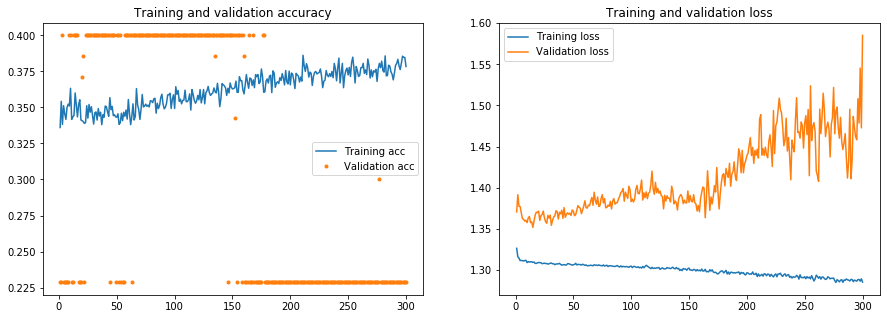

In [26]:
for history_idx, history in enumerate(histories):
    plot_learning_curve(history, loo_idx=history_idx, save=False)

In [27]:
pred = model.predict(X_test)

In [28]:
y_label = np.argmax(y_test,1)
y_fit = np.argmax(pred,1)

confusion_mat = confusion_matrix(y_label, y_fit)
confusion_mat

array([[ 0,  0,  8,  0],
       [ 0,  0, 10,  0],
       [ 0,  0, 18,  0],
       [ 0,  0, 17,  0]])

In [29]:
y_label

array([0, 3, 3, 1, 2, 3, 3, 2, 1, 2, 3, 3, 3, 1, 2, 0, 0, 3, 3, 3, 3, 2,
       1, 1, 3, 0, 0, 3, 1, 2, 1, 2, 0, 2, 2, 0, 3, 3, 2, 2, 2, 2, 2, 3,
       2, 2, 1, 0, 1, 2, 2, 3, 1])

In [30]:
y_fit

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2])

In [31]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import precision_recall_fscore_support as score

In [32]:
accuracy = accuracy_score(y_label,y_fit)
precision, recall, fscore, support = score(y_label, y_fit)

print('accuracy: {}'.format(accuracy))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

accuracy: 0.33962264150943394
precision: [0.         0.         0.33962264 0.        ]
recall: [0. 0. 1. 0.]
fscore: [0.         0.         0.50704225 0.        ]
support: [ 8 10 18 17]


/root/miniconda3/envs/tf13/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/root/miniconda3/envs/tf13/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


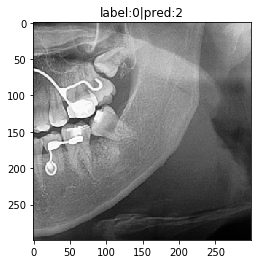

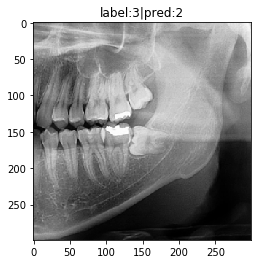

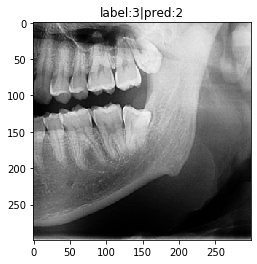

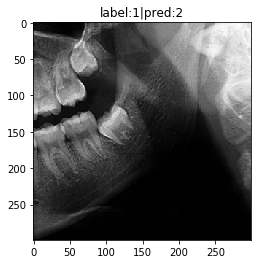

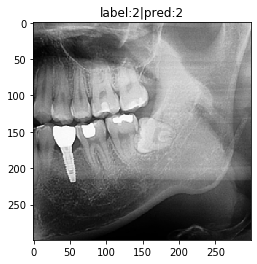

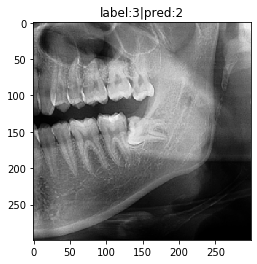

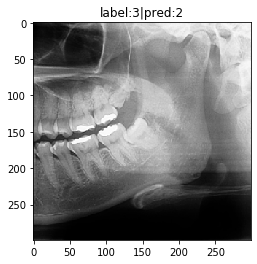

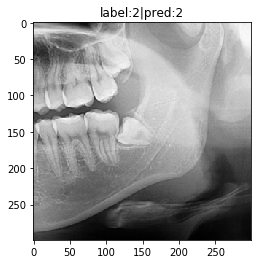

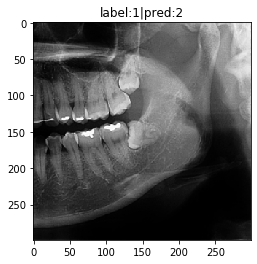

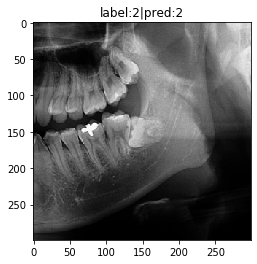

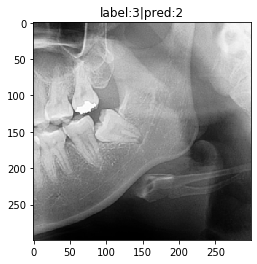

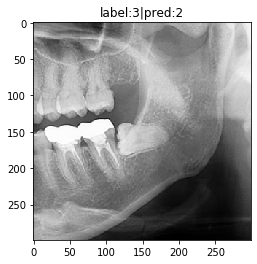

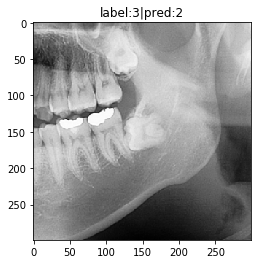

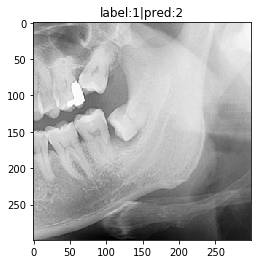

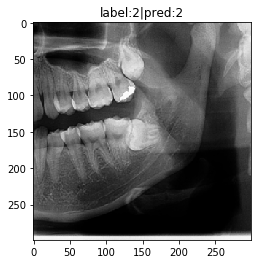

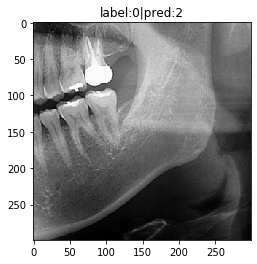

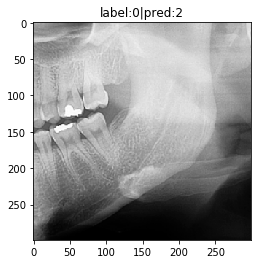

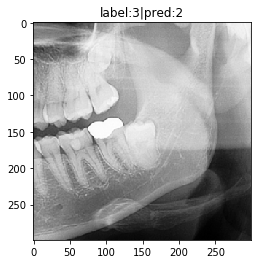

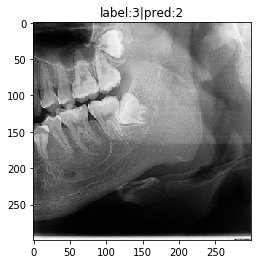

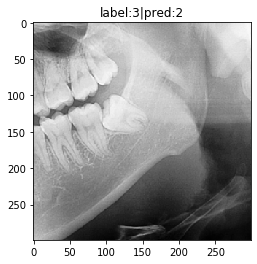

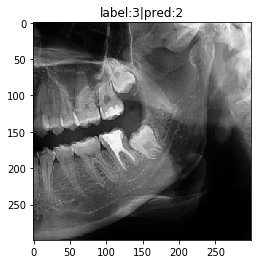

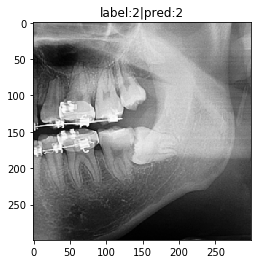

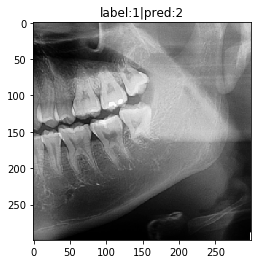

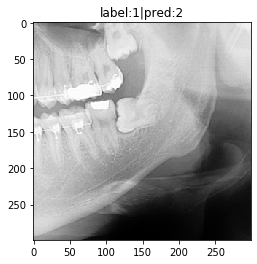

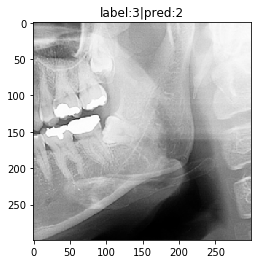

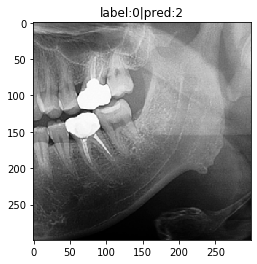

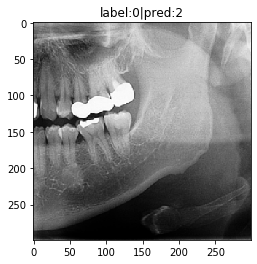

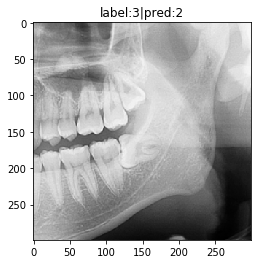

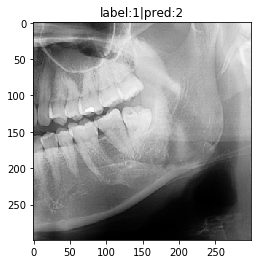

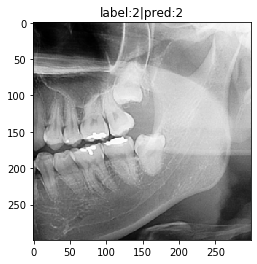

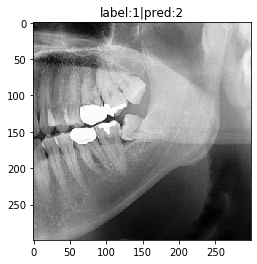

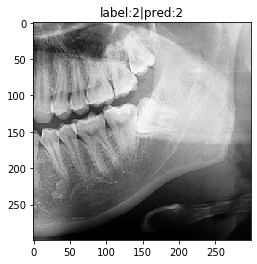

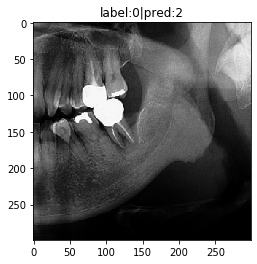

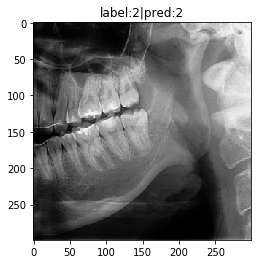

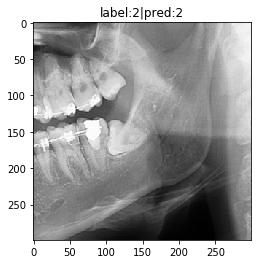

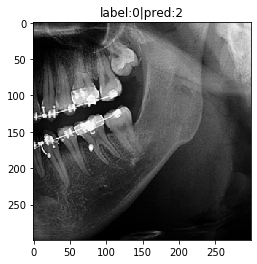

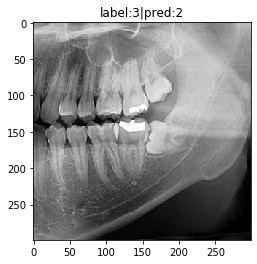

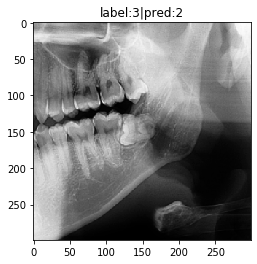

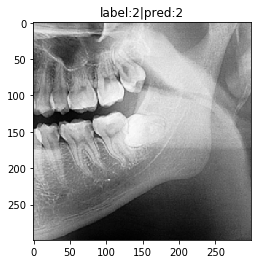

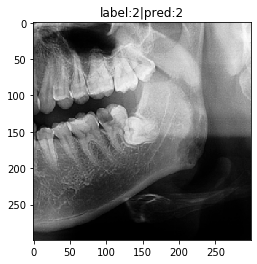

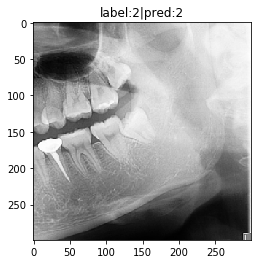

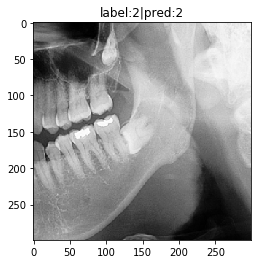

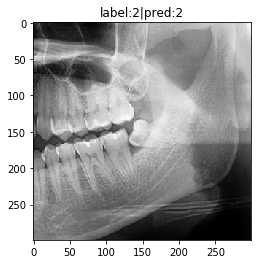

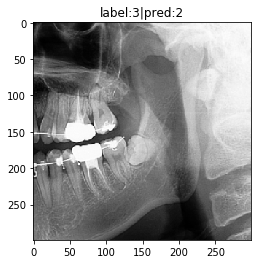

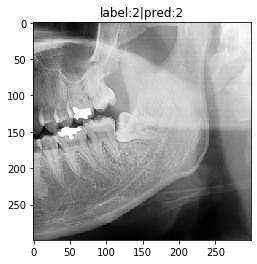

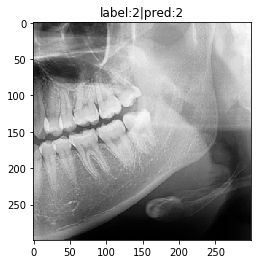

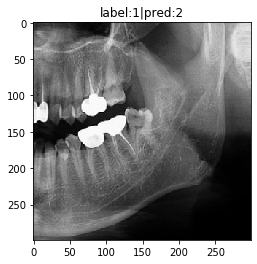

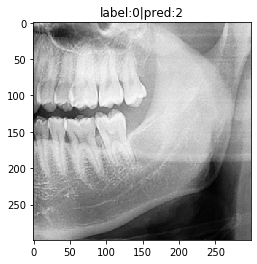

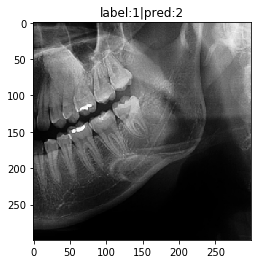

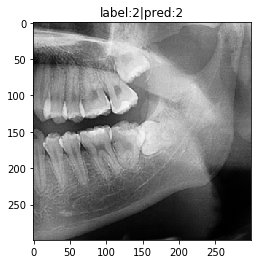

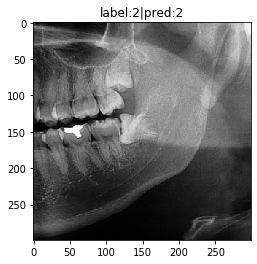

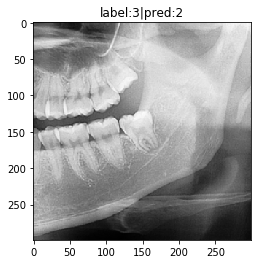

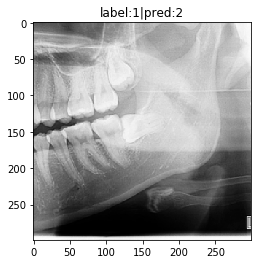

In [33]:
for x in range(len(pred)):
    plt.figure()
    plt.title('label:'+str(y_label[x])+'|pred:'+str(y_fit[x]))
    plt.imshow(X_test[x,:,:,0],cmap='Greys_r')

In [ ]:
a